In [16]:
#to figure out M6 post and to_world.
import os
import numpy as np
from numpy import ndarray
from fractions import gcd
from numbers import Number
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
import torch.optim as optim
import random
from utils import collate_fn,gpu,to_long
import logging
from memory_profiler import profile
import gc
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union
import numpy as np
from scipy import sparse
import copy
import torch
from utils import poly_gon_and_line,bboxes_overlapping,bboxes_of_poly, to_local
import matplotlib.pyplot as plt
import math

config = dict()
config['n_actornet'] = 128
config['num_epochs'] = 150
config['lr'] = 1e-3
config["num_scales"] = 6
config["n_map"] = 128
config["n_actor"] = 128
config["actor2map_dist"] = 7.0
config["map2actor_dist"] = 6.0
config["actor2actor_dist"] = 100.0
config["num_mods"] = 6
config["pred_size"] = 80
config["pred_step"] = 1
config["num_preds"] = config["pred_size"] // config["pred_step"]
config["cls_th"] = 2.0 #5.0
config["cls_ignore"] = 0.2
config["mgn"] = 0.2
config["cls_coef"] = 1.0
config["reg_coef"] = 1.0
config["metrics_preds"] = [30,50,80]
config["dim_feats"] = {'xyvp':[6,2], 'xyz':[4,3], 'xy':[3,2], 'xyp':[4,2], 'vp':[4,2]}
config['type_feats'] = 'vp'
config['f'] = '1f'
config['train_split'] = '/home/avt/prediction/Waymo/data_processed/' + config['type_feats'] + '/train_' + config['f'] 
config['val_split'] = '/home/avt/prediction/Waymo/data_processed/' + config['type_feats'] + '/val_' + config['f']


In [52]:
path = '/home/avt/prediction/Waymo/data_processed/xy/train_1f/0_3.pt'
qq = torch.load(path)
qq['object_types']

['TYPE_PEDESTRIAN',
 'TYPE_PEDESTRIAN',
 'TYPE_PEDESTRIAN',
 'TYPE_PEDESTRIAN',
 'TYPE_PEDESTRIAN',
 'TYPE_PEDESTRIAN',
 'TYPE_PEDESTRIAN',
 'TYPE_PEDESTRIAN',
 'TYPE_PEDESTRIAN',
 'TYPE_PEDESTRIAN',
 'TYPE_PEDESTRIAN',
 'TYPE_PEDESTRIAN',
 'TYPE_PEDESTRIAN',
 'TYPE_PEDESTRIAN',
 'TYPE_PEDESTRIAN',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'TYPE_VEHICLE',
 'T

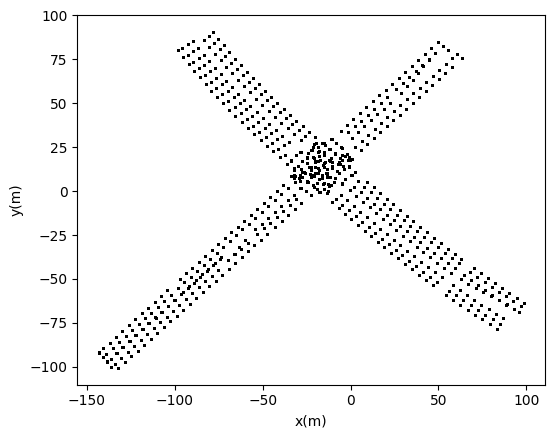

In [50]:
path = '/home/avt/prediction/Waymo/data_processed/xy/train_1f/0_3.pt'
qq = torch.load(path)
ctrs = qq['graph']['ctrs']

for c in ctrs:
    plt.scatter(ctrs.T[0] ,ctrs.T[1], c = 'black',s = 0.05)

plt.gca().set_aspect('equal')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.show()

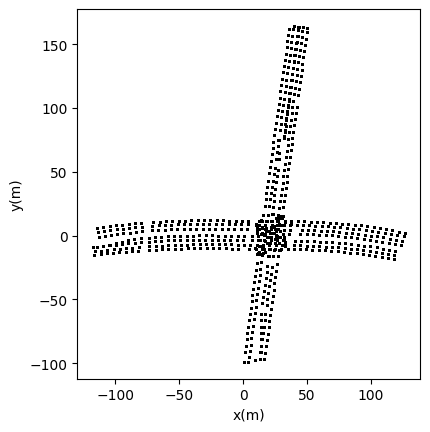

In [51]:
path = '/home/avt/prediction/Waymo/data_processed/xy/train_1f/1_3.pt'
qq = torch.load(path)
ctrs = qq['graph']['ctrs']

for c in ctrs:
    plt.scatter(ctrs.T[0] ,ctrs.T[1], c = 'black',s = 0.05)

plt.gca().set_aspect('equal')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.show()

In [ ]:
import sys
sys.path.append('/home/avt/prediction/Waymo/working/')

from math import gcd
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from typing import Dict, List, Tuple, Union
from utils import to_long, gpu

# config["dim_feats"] = {'xyvp':[6,2], 'xyz':[4,3], 'xy':[3,2],  'xyp':[4,2]}

class Linear(nn.Module):
    def __init__(self, n_in, n_out, norm='GN', ng=32, act=True):
        super(Linear, self).__init__()
        assert(norm in ['GN', 'BN', 'SyncBN'])

        self.linear = nn.Linear(n_in, n_out, bias=False)
        
        if norm == 'GN':
            self.norm = nn.GroupNorm(gcd(ng, n_out), n_out)
        elif norm == 'BN':
            self.norm = nn.BatchNorm1d(n_out)
        else:
            exit('SyncBN has not been added!')
        
        self.relu = nn.ReLU(inplace=True)
        self.act = act

    def forward(self, x):
        out = self.linear(x)
        out = self.norm(out)
        if self.act:
            out = self.relu(out)
        return out


class LinearRes(nn.Module):
    def __init__(self, n_in, n_out, norm='GN', ng=32):
        super(LinearRes, self).__init__()
        assert(norm in ['GN', 'BN', 'SyncBN'])

        self.linear1 = nn.Linear(n_in, n_out, bias=False)
        self.linear2 = nn.Linear(n_out, n_out, bias=False)
        self.relu = nn.ReLU(inplace=True)

        if norm == 'GN':
            self.norm1 = nn.GroupNorm(gcd(ng, n_out), n_out)
            self.norm2 = nn.GroupNorm(gcd(ng, n_out), n_out)
        elif norm == 'BN':
            self.norm1 = nn.BatchNorm1d(n_out)
            self.norm2 = nn.BatchNorm1d(n_out)
        else:   
            exit('SyncBN has not been added!')

        if n_in != n_out:
            if norm == 'GN':
                self.transform = nn.Sequential(
                    nn.Linear(n_in, n_out, bias=False),
                    nn.GroupNorm(gcd(ng, n_out), n_out))
            elif norm == 'BN':
                self.transform = nn.Sequential(
                    nn.Linear(n_in, n_out, bias=False),
                    nn.BatchNorm1d(n_out))
            else:
                exit('SyncBN has not been added!')
        else:
            self.transform = None

    def forward(self, x):
        out = self.linear1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.norm2(out)

        if self.transform is not None:
            out += self.transform(x)
            
        else:
            out += x
        out = self.relu(out) 

        return out


class Conv1d(nn.Module):
    def __init__(self, n_in, n_out, kernel_size=3, stride=1, norm='GN', ng=32, act=True):
        super(Conv1d, self).__init__()
        assert(norm in ['GN', 'BN', 'SyncBN'])

        self.conv = nn.Conv1d(n_in, n_out, kernel_size=kernel_size, padding=(int(kernel_size) - 1) // 2, stride=stride, bias=False)

        if norm == 'GN':
            self.norm = nn.GroupNorm(gcd(ng, n_out), n_out)
        elif norm == 'BN':
            self.norm = nn.BatchNorm1d(n_out)
        else:
            exit('SyncBN has not been added!')

        self.relu = nn.ReLU(inplace=True)
        self.act = act

    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        if self.act:
            out = self.relu(out)
        return out
 

class Res1d(nn.Module):
    def __init__(self, n_in, n_out, kernel_size=3, stride=1, norm='GN', ng=32, act=True):
        super(Res1d, self).__init__()
        assert(norm in ['GN', 'BN', 'SyncBN'])
        padding = (int(kernel_size) - 1) // 2
        self.conv1 = nn.Conv1d(n_in, n_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.conv2 = nn.Conv1d(n_out, n_out, kernel_size=kernel_size, padding=padding, bias=False)
        self.relu = nn.ReLU(inplace = True)

        # All use name bn1 and bn2 to load imagenet pretrained weights
        if norm == 'GN':
            self.bn1 = nn.GroupNorm(gcd(ng, n_out), n_out)
            self.bn2 = nn.GroupNorm(gcd(ng, n_out), n_out)
        elif norm == 'BN':
            self.bn1 = nn.BatchNorm1d(n_out)
            self.bn2 = nn.BatchNorm1d(n_out)
        else:
            exit('SyncBN has not been added!')

        if stride != 1 or n_out != n_in:
            if norm == 'GN':
                self.downsample = nn.Sequential(
                        nn.Conv1d(n_in, n_out, kernel_size=1, stride=stride, bias=False),
                        nn.GroupNorm(gcd(ng, n_out), n_out))
            elif norm == 'BN':
                self.downsample = nn.Sequential(
                        nn.Conv1d(n_in, n_out, kernel_size=1, stride=stride, bias=False),
                        nn.BatchNorm1d(n_out))
            else:
                exit('SyncBN has not been added!')
        else:
            self.downsample = None

        self.act = act

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            x = self.downsample(x)

        out += x
        if self.act:
            out = self.relu(out)
        return out


def actor_gather(actors: List[Tensor]) -> Tuple[Tensor, List[Tensor]]:
    """
    actors is data['feat']
     
    """

    batch_size = len(actors)
    num_actors = [len(x) for x in actors]

    actors = [torch.stack(x).transpose(1, 2) for x in actors]
    actors = torch.cat(actors, 0)

    actor_idcs = []
    count = 0
    for i in range(batch_size):
        idcs = torch.arange(count, count + num_actors[i]).to(actors.device)
        actor_idcs.append(idcs)
        count += num_actors[i]
    return actors, actor_idcs


def graph_gather(graphs):
    batch_size = len(graphs)
    node_idcs = []
    count = 0
    counts = []

    for i in range(batch_size):
        counts.append(count)
        idcs = torch.arange(count, count + graphs[i]["num_nodes"])
        node_idcs.append(idcs)
        count = count + graphs[i]["num_nodes"]

    graph = dict()
    graph["idcs"] = node_idcs
    graph["ctrs"] = [x["ctrs"] for x in graphs]

    graph['feats'] = torch.cat([x['feats'] for x in graphs], 0)

    for k1 in ["pre", "suc"]:
        graph[k1] = []
        for i in range(len(graphs[0]["pre"])):
            graph[k1].append(dict())
            for k2 in ["u", "v"]:
                graph[k1][i][k2] = torch.cat(
                    [graphs[j][k1][i][k2] + counts[j] for j in range(batch_size)], 0
                )

    for k1 in ["left", "right"]:
        graph[k1] = dict()
        for k2 in ["u", "v"]:
            temp = [graphs[i][k1][k2] + counts[i] for i in range(batch_size)]
            temp = [
                x if x.dim() > 0 else graph["pre"][0]["u"].new().resize_(0)
                for x in temp
            ]
            graph[k1][k2] = torch.cat(temp)
    
    return graph


class ActorNet(nn.Module):
    def __init__(self,config) -> None:
        super(ActorNet,self).__init__()
        self.config = config
        norm = "GN"
        ng = 1

        n_in = config['dim_feats'][config['type_feats']][0]
        n_out = [32, 64, 128]
        blocks = [Res1d, Res1d, Res1d]
        num_blocks = [2, 2, 2]

        groups = []

        for i in range(len(num_blocks)):

            group = []

            if i == 0:
                group.append(blocks[i](n_in, n_out[i], norm=norm, ng=ng))
            else:
                group.append(blocks[i](n_in, n_out[i], stride=2, norm=norm, ng=ng))

            for j in range(1, num_blocks[i]):
                group.append(blocks[i](n_out[i], n_out[i], norm=norm, ng=ng))
            
            groups.append(nn.Sequential(*group))
            
            n_in = n_out[i]

        self.groups = nn.ModuleList(groups)

        n = config['n_actornet']#128
        
        lateral = []
        for i in range(len(n_out)):
            lateral.append(Conv1d(n_out[i], n, norm=norm, ng=ng, act=False))
        self.lateral = nn.ModuleList(lateral)

        self.outlayer = Res1d(n, n, norm=norm, ng=ng)

    def forward(self, actors: Tensor) -> Tensor:
        #actors [batch_size,feature_dim(),time_step(11)]
        
        out = actors
        pad = torch.ones(out.size(0),out.size(1),1)

        out = torch.cat((pad,out),2)

        outputs = []
        for i in range(len(self.groups)):
            out = self.groups[i](out)
            outputs.append(out)
        
        out = self.lateral[-1](outputs[-1])

        for i in range(len(outputs) - 2, -1, -1):

            out = F.interpolate(out, scale_factor=2, mode="linear", align_corners=False)
            tmp = self.lateral[i](outputs[i])

            # if out.shape != tmp.shape:
            #     out = out[:,:,:tmp.shape[2]]

            out += tmp
        
        out = self.outlayer(out)[:,:,-1]

        return out
    

class MapNet(nn.Module):
  
    def __init__(self, config):
        super(MapNet, self).__init__()
        self.config = config
        n_map = 128
        norm = "GN"
        ng = 1
        n_in = config['dim_feats'][config['type_feats']][1]

        self.input = nn.Sequential(
            nn.Linear(n_in, n_map),
            nn.ReLU(inplace=True),
            Linear(n_map, n_map, norm=norm, ng=ng, act=False),
        )
        self.seg = nn.Sequential(
            nn.Linear(n_in, n_map),
            nn.ReLU(inplace=True),
            Linear(n_map, n_map, norm=norm, ng=ng, act=False),
        )

        keys = ["ctr", "norm", "ctr2", "left", "right"]
        for i in range(config["num_scales"]):
            keys.append("pre" + str(i))
            keys.append("suc" + str(i))

        fuse = dict()
        for key in keys:
            fuse[key] = []

        for i in range(4):
            for key in fuse:
                if key in ["norm"]:
                    fuse[key].append(nn.GroupNorm(gcd(ng, n_map), n_map))
                elif key in ["ctr2"]:
                    fuse[key].append(Linear(n_map, n_map, norm=norm, ng=ng, act=False))
                else:
                    fuse[key].append(nn.Linear(n_map, n_map, bias=False))

        for key in fuse:
            fuse[key] = nn.ModuleList(fuse[key])
        self.fuse = nn.ModuleDict(fuse)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, graph):
        if (
            len(graph["feats"]) == 0
            or len(graph["pre"][-1]["u"]) == 0
            or len(graph["suc"][-1]["u"]) == 0
        ):
            temp = graph["feats"]
            return (
                temp.new().resize_(0),
                [temp.new().long().resize_(0) for x in graph["node_idcs"]],
                temp.new().resize_(0),
            )

        ctrs = torch.cat(graph["ctrs"], 0)
        feat = self.input(ctrs)
        feat += self.seg(graph["feats"])
        feat = self.relu(feat)

        """fuse map"""
        res = feat
        for i in range(len(self.fuse["ctr"])):
            temp = self.fuse["ctr"][i](feat)
            for key in self.fuse:
                if key.startswith("pre") or key.startswith("suc"):
                    k1 = key[:3]
                    k2 = int(key[3:])
                    temp.index_add_(
                        0,
                        graph[k1][k2]["u"],
                        self.fuse[key][i](feat[graph[k1][k2]["v"]]),
                    )

            if len(graph["left"]["u"] > 0):
                temp.index_add_(
                    0,
                    graph["left"]["u"],
                    self.fuse["left"][i](feat[graph["left"]["v"]]),
                )
            if len(graph["right"]["u"] > 0):
                temp.index_add_(
                    0,
                    graph["right"]["u"],
                    self.fuse["right"][i](feat[graph["right"]["v"]]),
                )

            feat = self.fuse["norm"][i](temp)
            feat = self.relu(feat)

            feat = self.fuse["ctr2"][i](feat)
            feat += res
            feat = self.relu(feat)
            res = feat

        return feat


class Att(nn.Module):
    def __init__(self, n_agt: int, n_ctx: int, config) -> None:
        super(Att, self).__init__()
        self.config = config
        norm = "GN"
        ng = 1
        n_in = config['dim_feats'][config['type_feats']][1]

        self.dist = nn.Sequential(
            nn.Linear(n_in, n_ctx),
            nn.ReLU(inplace=True),
            Linear(n_ctx, n_ctx, norm=norm, ng=ng),
        )

        self.query = Linear(n_agt, n_ctx, norm=norm, ng=ng)

        self.ctx = nn.Sequential(
            Linear(3 * n_ctx, n_agt, norm=norm, ng=ng),
            nn.Linear(n_agt, n_agt, bias=False),
        )

        self.agt = nn.Linear(n_agt, n_agt, bias=False)
        self.norm = nn.GroupNorm(gcd(ng, n_agt), n_agt)
        self.linear = Linear(n_agt, n_agt, norm=norm, ng=ng, act=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, agts: Tensor, agt_idcs: List[Tensor], agt_ctrs: List[Tensor], ctx: Tensor, ctx_idcs: List[Tensor], ctx_ctrs: List[Tensor], dist_th: float) -> Tensor:
        # feat, graph["idcs"], graph["ctrs"], actors, actor_idcs, actor_ctrs, config["actor2map_dist"]      
        res = agts
        if len(ctx) == 0:
            agts = self.agt(agts)
            agts = self.relu(agts)
            agts = self.linear(agts)
            agts += res
            agts = self.relu(agts)
            return agts

        batch_size = len(agt_idcs)
        hi, wi = [], []
        hi_count, wi_count = 0, 0
        n_c = self.config['dim_feats'][self.config['type_feats']][1]

        
        for i in range(batch_size):
        
            dist = agt_ctrs[i].view(-1, 1, n_c) - ctx_ctrs[i].view(1, -1, n_c)
            dist = torch.sqrt((dist ** 2).sum(2))
            mask = dist <= dist_th

            idcs = torch.nonzero(mask, as_tuple=False)
            if len(idcs) == 0:
                continue

            hi.append(idcs[:, 0] + hi_count)
            wi.append(idcs[:, 1] + wi_count)
            hi_count += len(agt_idcs[i])
            wi_count += len(ctx_idcs[i])

        if hi == []:
            print('WARNING!!! - Attention')

        hi = torch.cat(hi, 0)
        wi = torch.cat(wi, 0)

        agt_ctrs = torch.cat(agt_ctrs, 0)
        ctx_ctrs = torch.cat(ctx_ctrs, 0)
        dist = agt_ctrs[hi] - ctx_ctrs[wi]
        dist = self.dist(dist)

        query = self.query(agts[hi])

        ctx = ctx[wi]
        ctx = torch.cat((dist, query, ctx), 1)
        ctx = self.ctx(ctx)

        agts = self.agt(agts)
        agts.index_add_(0, hi, ctx)
        agts = self.norm(agts)
        agts = self.relu(agts)

        agts = self.linear(agts)
        agts += res
        agts = self.relu(agts)

        return agts


class A2M(nn.Module):
    """
    Actor to Map Fusion:  fuses real-time traffic information from
    actor nodes to lane nodes
    """
    def __init__(self, config):
        super(A2M, self).__init__()
        self.config = config
        n_map = config["n_map"]
        norm = "GN"
        ng = 1

        """fuse meta, static, dyn"""
        self.meta = Linear(n_map, n_map, norm=norm, ng=ng)
        att = []
        for i in range(2):
            att.append(Att(n_map, config["n_actor"], config))
        self.att = nn.ModuleList(att)

    def forward(self, feat: Tensor, graph: Dict[str, Union[List[Tensor], Tensor, List[Dict[str, Tensor]], Dict[str, Tensor]]], actors: Tensor, actor_idcs: List[Tensor], actor_ctrs: List[Tensor]) -> Tensor:
        """meta, static and dyn fuse using attention"""
        
        feat = self.meta(feat)

        for i in range(len(self.att)):
            feat = self.att[i](
                feat,
                graph["idcs"],
                graph["ctrs"],
                actors,
                actor_idcs,
                actor_ctrs,
                self.config["actor2map_dist"],
            )
        return feat


class M2M(nn.Module):
 
    def __init__(self, config):
        super(M2M, self).__init__()
        self.config = config
        n_map = config["n_map"]
        norm = "GN"
        ng = 1

        keys = ["ctr", "norm", "ctr2", "left", "right"]
        for i in range(config["num_scales"]):
            keys.append("pre" + str(i))
            keys.append("suc" + str(i))

        fuse = dict()
        for key in keys:
            fuse[key] = []

        for i in range(4):
            for key in fuse:
                if key in ["norm"]:
                    fuse[key].append(nn.GroupNorm(gcd(ng, n_map), n_map))
                elif key in ["ctr2"]:
                    fuse[key].append(Linear(n_map, n_map, norm=norm, ng=ng, act=False))
                else:
                    fuse[key].append(nn.Linear(n_map, n_map, bias=False))

        for key in fuse:
            fuse[key] = nn.ModuleList(fuse[key])
        self.fuse = nn.ModuleDict(fuse)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, feat: Tensor, graph: Dict) -> Tensor:
        """fuse map"""
        res = feat
        for i in range(len(self.fuse["ctr"])):
            temp = self.fuse["ctr"][i](feat)
            for key in self.fuse:
                if key.startswith("pre") or key.startswith("suc"):
                    k1 = key[:3]
                    k2 = int(key[3:])
                    temp.index_add_(
                        0,
                        graph[k1][k2]["u"],
                        self.fuse[key][i](feat[graph[k1][k2]["v"]]),
                    )

            if len(graph["left"]["u"] > 0):
                temp.index_add_(
                    0,
                    graph["left"]["u"],
                    self.fuse["left"][i](feat[graph["left"]["v"]]),
                )
            if len(graph["right"]["u"] > 0):
                temp.index_add_(
                    0,
                    graph["right"]["u"],
                    self.fuse["right"][i](feat[graph["right"]["v"]]),
                )

            feat = self.fuse["norm"][i](temp)
            feat = self.relu(feat)

            feat = self.fuse["ctr2"][i](feat)
            feat += res
            feat = self.relu(feat)
            res = feat
        return feat


# class M2A(nn.Module):
#     """
#     The lane to actor block fuses updated
#         map information from lane nodes to actor nodes
#     """
#     def __init__(self, config):
#         super(M2A, self).__init__()
#         self.config = config
#         norm = "GN"
#         ng = 1

#         n_actor = config["n_actor"]
#         n_map = config["n_map"]

#         att = []
#         for i in range(2):
#             att.append(Att(n_actor, n_map, config))
#         self.att = nn.ModuleList(att)

#     def forward(self, actors: Tensor, actor_idcs: List[Tensor], actor_ctrs: List[Tensor], nodes: Tensor, node_idcs: List[Tensor], node_ctrs: List[Tensor]) -> Tensor:
#         for i in range(len(self.att)):
#             actors = self.att[i](
#                 actors,
#                 actor_idcs,
#                 actor_ctrs,
#                 nodes,
#                 node_idcs,
#                 node_ctrs,
#                 self.config["map2actor_dist"],
#             )
#         return actors


class A2A(nn.Module):
    """
    The actor to actor block performs interactions among actors.
    """
    def __init__(self, config):
        super(A2A, self).__init__()
        self.config = config
        norm = "GN"
        ng = 1

        n_actor = config["n_actor"]

        att = []
        for i in range(2):
            att.append(Att(n_actor, n_actor, config))
        self.att = nn.ModuleList(att)

    def forward(self, actors: Tensor, actor_idcs: List[Tensor], actor_ctrs: List[Tensor]) -> Tensor:
        for i in range(len(self.att)):
            actors = self.att[i](
                actors,
                actor_idcs,
                actor_ctrs,
                actors,
                actor_idcs,
                actor_ctrs,
                self.config["actor2actor_dist"],
            )
        return actors


class PredNet(nn.Module):
    def __init__(self, config):
        super(PredNet, self).__init__()
        self.config = config
        norm = "GN"
        ng = 1

        n_actor = config["n_actor"]

        pred = []
        for i in range(config["num_mods"]):
            pred.append(
                nn.Sequential(
                    LinearRes(n_actor, n_actor, norm=norm, ng=ng),
                    nn.Linear(n_actor, 2 * config["num_preds"]),
                )
            )
        self.pred = nn.ModuleList(pred)

        self.att_dest = AttDest(n_actor)
        self.cls = nn.Sequential(
            LinearRes(n_actor, n_actor, norm=norm, ng=ng), nn.Linear(n_actor, 1)
        )

    def forward(self, actors: Tensor, actor_idcs: List[Tensor], actor_ctrs: List[Tensor]) -> Dict[str, List[Tensor]]:
        preds = []
        for i in range(len(self.pred)):
            preds.append(self.pred[i](actors))
        reg = torch.cat([x.unsqueeze(1) for x in preds], 1)
        reg = reg.view(reg.size(0), reg.size(1), -1, 2)

        n_c = self.config['dim_feats'][self.config['type_feats']][1]
        for i in range(len(actor_idcs)):
            idcs = actor_idcs[i]
            ctrs = actor_ctrs[i].view(-1, 1, 1, n_c)
            reg[idcs] = reg[idcs] + ctrs[:,:,:,:2]

        dest_ctrs = reg[:, :, -1].detach()
        feats = self.att_dest(actors, torch.cat(actor_ctrs, 0), dest_ctrs)
        cls = self.cls(feats).view(-1, self.config["num_mods"])

        cls, sort_idcs = cls.sort(1, descending=True)
        row_idcs = torch.arange(len(sort_idcs)).long().to(sort_idcs.device)
        row_idcs = row_idcs.view(-1, 1).repeat(1, sort_idcs.size(1)).view(-1)
        sort_idcs = sort_idcs.view(-1)
        reg = reg[row_idcs, sort_idcs].view(cls.size(0), cls.size(1), -1, 2)

        out = dict()
        out["cls"], out["reg"] = [], []
        for i in range(len(actor_idcs)):
            idcs = actor_idcs[i]
            out["cls"].append(cls[idcs])
            out["reg"].append(reg[idcs])
        return out


class AttDest(nn.Module):
    def __init__(self, n_agt: int):
        super(AttDest, self).__init__()
        norm = "GN"
        ng = 1

        self.dist = nn.Sequential(
            nn.Linear(2, n_agt),
            nn.ReLU(inplace=True),
            Linear(n_agt, n_agt, norm=norm, ng=ng),
        )

        self.agt = Linear(2 * n_agt, n_agt, norm=norm, ng=ng)

    def forward(self, agts: Tensor, agt_ctrs: Tensor, dest_ctrs: Tensor) -> Tensor:
        n_agt = agts.size(1)
        num_mods = dest_ctrs.size(1)

        dist = (agt_ctrs[:,:2].unsqueeze(1) - dest_ctrs).view(-1, 2)
        dist = self.dist(dist)
        agts = agts.unsqueeze(1).repeat(1, num_mods, 1).view(-1, n_agt)

        agts = torch.cat((dist, agts), 1)
        agts = self.agt(agts)
        return agts


class GreatNet(nn.Module):
    def __init__(self,config) -> None:
        super().__init__()

        self.config = config

        self.actor_net = ActorNet(config)
        self.map_net = MapNet(config)

        self.a2m = A2M(config)
        self.m2m = M2M(config)
        self.m2a = M2A(config)
        self.a2a = A2A(config)
        
        self.pred_net = PredNet(config)
    
    def forward(self, data: Dict) -> Tensor:

        actors, actor_idcs = actor_gather(data["feats"])
        actor_ctrs = [torch.stack(i,0) for i in data["ctrs"]]

        actors = gpu(actors)
        actor_idcs = gpu(actor_idcs)
        actor_ctrs = gpu(actor_ctrs)

        actors = self.actor_net(actors)

        #------------------------------------------------------------#

        graph = to_long(data['graph'])
        graph = graph_gather(graph)

        graph = gpu(graph)

        nodes, node_idcs, node_ctrs = self.map_net(graph)

        #------------------------------------------------------------#
        
        nodes = self.a2m(nodes, graph, actors, actor_idcs, actor_ctrs)
        nodes = self.m2m(nodes, graph)
        actors = self.m2a(actors, actor_idcs, actor_ctrs, nodes, node_idcs, node_ctrs)
        actors = self.a2a(actors, actor_idcs, actor_ctrs)
        
        out = self.pred_net(actors, actor_idcs, actor_ctrs)
        rot, orig = gpu(data["rot"]), gpu(data["orig"])

        # to_global
        for i in range(len(out["reg"])):
            out["reg"][i] = torch.matmul(out["reg"][i], rot[i]) + orig[i][:2].view(1, 1, 1, -1)

        return out



In [ ]:

class W_Dataset(Dataset):
    def __init__(self,path) -> None:

        self.path = path
        self.files = os.listdir(path)
    
    def __getitem__(self, index) -> dict:

        data_path = os.path.join(self.path,self.files[index])
        data = torch.load(data_path)

        return data
    
    def __len__(self) -> int:

        return len(self.files)

In [ ]:
batch_size = 4
dataset_train = W_Dataset(config['train_split'])
train_loader = DataLoader(dataset_train, 
                        batch_size = batch_size ,
                        collate_fn = collate_fn, 
                        shuffle = True, 
                        drop_last=True)

In [ ]:
for i, data in enumerate(train_loader):
        if i > 0:
            break
        zz = data

In [ ]:

class SpAtt(nn.Module):
    def __init__(self, n_agt: int, n_ctx: int, config) -> None:
        super(SpAtt, self).__init__()
        self.config = config
        norm = "GN"
        ng = 1
        n_in = config['dim_feats'][config['type_feats']][1]

        self.dist = nn.Sequential(
            nn.Linear(n_in, n_ctx),
            nn.ReLU(inplace=True),
            Linear(n_ctx, n_ctx, norm=norm, ng=ng),
        )

        self.query = Linear(n_agt, n_ctx, norm=norm, ng=ng)

        self.ctx = nn.Sequential(
            Linear(3 * n_ctx, n_agt, norm=norm, ng=ng),
            nn.Linear(n_agt, n_agt, bias=False),
        )

        self.agt = nn.Linear(n_agt, n_agt, bias=False)
        self.norm = nn.GroupNorm(gcd(ng, n_agt), n_agt)
        self.linear = Linear(n_agt, n_agt, norm=norm, ng=ng, act=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, agts: Tensor, agt_idcs: List[Tensor], agt_ctrs: List[Tensor], ctx: Tensor, ctx_idcs: List[Tensor], ctx_ctrs: List[Tensor], dist_th: float, graph: Dict) -> Tensor:
        # ctx = nodes, agts = objects
        # get the features of nodes(current, 6 sucs) into  objects
        res = agts
        if len(ctx) == 0:
            agts = self.agt(agts)
            agts = self.relu(agts)
            agts = self.linear(agts)
            agts += res
            agts = self.relu(agts)
            return agts

        batch_size = len(agt_idcs)
        hi, wi = [], []
        hi_count, wi_count = 0, 0
        n_c = self.config['dim_feats'][self.config['type_feats']][1]

        
        for i in range(batch_size):

            dist = agt_ctrs[i].view(-1, 1, n_c) - ctx_ctrs[i].view(1, -1, n_c)
            dist = torch.sqrt((dist ** 2).sum(2))
            mask = dist <= dist_th

            idcs = torch.nonzero(mask, as_tuple=False)

            if len(idcs) == 0:
                continue

            hi.append(idcs[:, 0] + hi_count)
            wi.append(idcs[:, 1] + wi_count)
            hi_count += len(agt_idcs[i])
            wi_count += len(ctx_idcs[i])


        hi = torch.cat(hi, 0)
        wi = torch.cat(wi, 0)
        agt_ctrs = torch.cat(agt_ctrs, 0)
        ctx_ctrs = torch.cat(ctx_ctrs, 0)

        # get the indx of all the sucs given wi
        #(1) get the sparse matrix of (hi, wi)
        #(2) have the sparse matrix of (wi, suc_i) in graph['suc']
        #(3) get the sparse matrix of (hi, suc_i)

        num_agts = len(agt_ctrs)
        num_nodes = len(ctx_ctrs)

        indcs = torch.stack((hi,wi))
        value = torch.ones(len(hi))
        size = torch.Size([num_agts, num_nodes])
        sp_hw = torch.sparse_coo_tensor(indcs, value, size)
        sp_final = sp_hw.clone()

        for i in range(len(graph['suc'])):
            u = graph['suc'][i]['u']
            v = graph['suc'][i]['v']
            indcs = torch.stack((u,v))
            value = torch.ones(len(u))
            size = torch.Size([num_nodes, num_nodes])
            sp_uv = torch.sparse_coo_tensor(indcs, value, size)
            sp_final += torch.matmul(sp_hw,sp_uv)

        hi = sp_final.coalesce().indices()[0]
        wi = sp_final.coalesce().indices()[1]

        # conduct sparse spatial attention given (hi, suc_i)
        dist = agt_ctrs[hi] - ctx_ctrs[wi]
        dist = self.dist(dist)

        query = self.query(agts[hi])

        ctx = ctx[wi]
        ctx = torch.cat((dist, query, ctx), 1)
        ctx = self.ctx(ctx)

        agts = self.agt(agts)
        agts.index_add_(0, hi, ctx)
        agts = self.norm(agts)
        agts = self.relu(agts)

        agts = self.linear(agts)
        agts += res
        agts = self.relu(agts)

        return agts



In [ ]:
class M2A(nn.Module):
    """
    The lane to actor block fuses updated
        map information from lane nodes to actor nodes
    """
    def __init__(self, config):
        super(M2A, self).__init__()
        self.config = config
        norm = "GN"
        ng = 1

        n_actor = config["n_actor"]
        n_map = config["n_map"]

        att = []
        for i in range(2):
            att.append(SpAtt(n_actor, n_map, config))
        self.att = nn.ModuleList(att)

    def forward(self, actors: Tensor, actor_idcs: List[Tensor], actor_ctrs: List[Tensor], nodes: Tensor, graph: Dict) -> Tensor:
        
        node_idcs, node_ctrs = graph["idcs"], graph["ctrs"]
        
        for i in range(len(self.att)):
            actors = self.att[i](
                actors,
                actor_idcs,
                actor_ctrs,
                nodes,
                node_idcs,
                node_ctrs,
                self.config["map2actor_dist"],
                graph
            )
            
        return actors


In [ ]:
actor_net = ActorNet(config)
map_net = MapNet(config)
a2m = A2M(config)
m2m = M2M(config)
m2a = M2A(config)
a2a = A2A(config)

In [ ]:
actors, actor_idcs = actor_gather(zz["feats"])
actor_ctrs = [torch.stack(i,0) for i in zz["ctrs"]]

actors = actor_net(actors)

graph = to_long(zz['graph'])
graph = graph_gather(graph)
nodes = map_net(graph)


In [ ]:
nodes = a2m(nodes, graph, actors, actor_idcs, actor_ctrs)
nodes = m2m(nodes, graph)
actors = m2a(actors, actor_idcs, actor_ctrs, nodes, graph)
actors = a2a(actors, actor_idcs, actor_ctrs)

In [ ]:
graph.keys()

In [ ]:
ctrs = torch.cat(graph['ctrs'],0)
len(ctrs)

In [ ]:
nodes.shape

In [ ]:
u1 = torch.ones(4,6)
pad = torch.zeros(4,1)

In [ ]:
u1,pad

In [ ]:
torch.concat([pad,u1],1)

In [ ]:
torch.cat([pad,u1],1)

In [ ]:
u1 = torch.tensor([0,1,1])
u2 = torch.tensor([1,1,2])

indcs = torch.stack((u1,u2))
value = torch.ones(len(u1)).to(torch.bool)
size = torch.Size([10,10])
sm = torch.sparse_coo_tensor(indcs, value, size)

In [ ]:
sm.to_dense()

In [ ]:
sm.coalesce().indices()[0]

In [7]:
import random
import numpy as np

In [14]:


random_float = random.uniform(0,2*np.pi)

print(random_float)

0.6517093863699129


In [63]:
embedding = nn.Embedding(10, 3)
indices = torch.tensor([[1, 3, 2, 5], [4, 6, 9, 6]]) 
embedded = embedding(indices)
embedded.shape


torch.Size([2, 4, 3])

In [57]:
indices

tensor([[1, 3, 2],
        [4, 6, 9]])

In [60]:
embedded.shape

torch.Size([2, 3, 3])

In [ ]:
xy = torch.tensor()